# Pre-processing

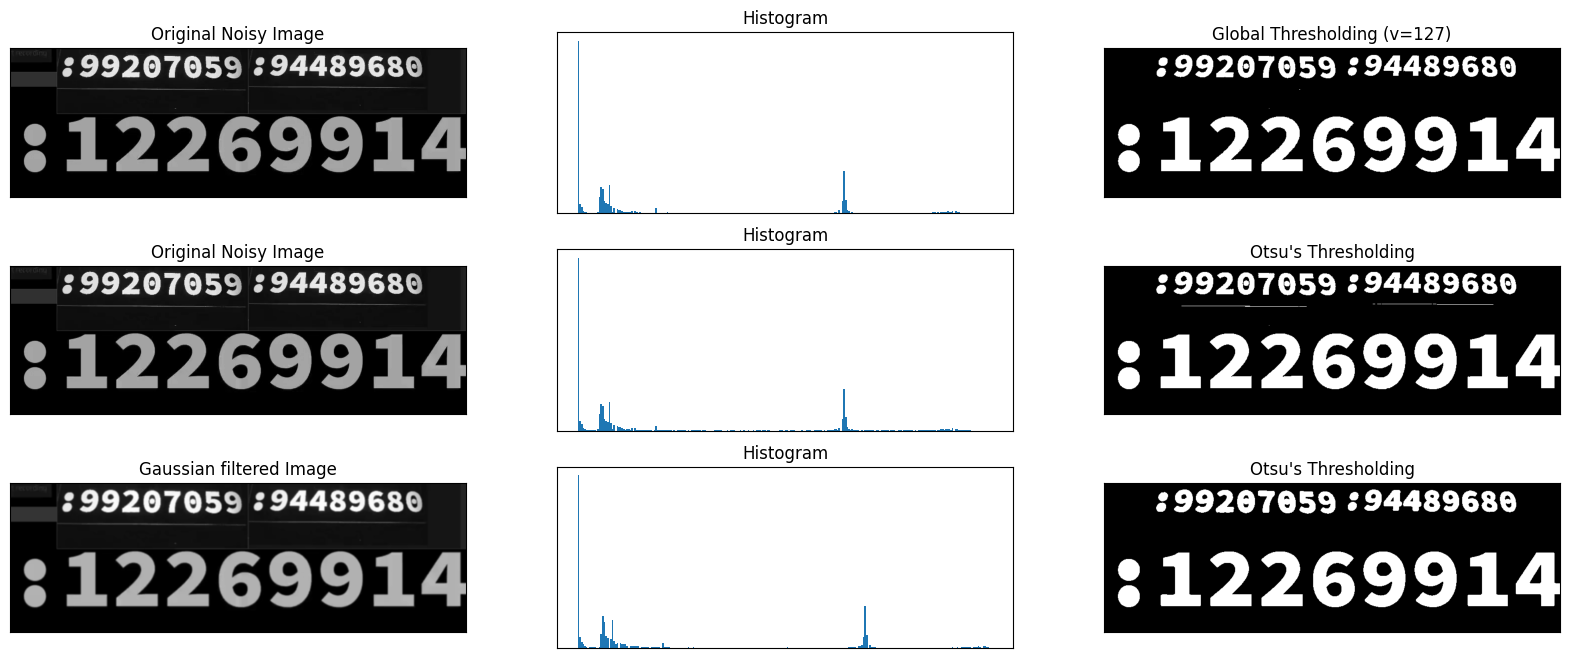

In [364]:
import cv2 as cv
import matplotlib.pyplot as plt

img = cv.imread('extracted_images/rtsp_to_webrtc/img000001.png', cv.IMREAD_GRAYSCALE)

# global thresholding
ret1,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
# Otsu's thresholding
ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv.GaussianBlur(img,(5,5),0)
ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]

titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

plt.figure(figsize=(20,8))
for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])

    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])

    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

# Building the algorithm for a single file

In [ ]:
filename = 'extracted_images/rtsp_to_webrtc/img000001.png'

img = cv.imread(filename, cv.IMREAD_GRAYSCALE)
_,img = cv.threshold(img,127,255,cv.THRESH_BINARY)

plt.imshow(img, 'gray')

In [486]:
import pytesseract
import re

custom_config = r'--oem 0 --psm 12 --dpi 300 -c tessedit_char_whitelist="0123456789 :"'
data = pytesseract.image_to_data(img, lang='eng', config=custom_config, nice=0, output_type=pytesseract.Output.DICT)
display(data)

matches = []
for i in range(len(data['text'])):
    text = data['text'][i]
    conf = float(data['conf'][i]) / 100
    matched = re.findall(r'\d{8}(?=[\s:]|$)', text)
    for match in matched:
        matches.append((conf, int(match)))

matches

{'level': [1, 2, 3, 4, 5],
 'page_num': [1, 1, 1, 1, 1],
 'block_num': [0, 1, 1, 1, 1],
 'par_num': [0, 0, 1, 1, 1],
 'line_num': [0, 0, 0, 1, 1],
 'word_num': [0, 0, 0, 0, 1],
 'left': [0, 38, 38, 38, 38],
 'top': [0, 30, 30, 30, 30],
 'width': [1181, 1090, 1090, 1090, 1090],
 'height': [195, 118, 118, 118, 118],
 'conf': [-1, -1, -1, -1, 83],
 'text': ['', '', '', '', ':01234567890']}

[(0.83, 34567890)]

# Expanding the algorithm for bulk processing

In [442]:
import cv2 as cv
import pytesseract
import glob
import re
import multiprocessing
import psutil
from tqdm import tqdm
from typing import List, Tuple

def extract_numbers(filename: str) -> List[Tuple[float, int]]:
    try:
        img = cv.imread(filename, cv.IMREAD_GRAYSCALE)
        _, img = cv.threshold(img, 127, 255, cv.THRESH_BINARY)

        # https://ai-facets.org/tesseract-ocr-best-practices/
        custom_config = r'--oem 0 --psm 12 --dpi 600 -c tessedit_char_whitelist="0123456789 :"'
        # custom_config = r'--oem 1 --psm 12'
        data = pytesseract.image_to_data(img, lang='eng', config=custom_config, output_type=pytesseract.Output.DICT)

        matches = []
        for i in range(len(data['text'])):
            text = data['text'][i]
            conf = float(data['conf'][i]) / 100
            matched = re.findall(r'\d{8}(?=[\s:]|$)', text)
            for match in matched:
                matches.append((conf, int(match)))

        return matches

    except (cv.error, pytesseract.TesseractError, ValueError):
        return []


def extract_numbers_parallel(pattern: str) -> List[Tuple[str, List[Tuple[float,int]]]]:
    files = glob.glob(pattern)

    # Get the number of CPUs and available memory
    num_cpus = psutil.cpu_count(logical=False)
    mem_stats = psutil.virtual_memory()
    mem_avail = mem_stats.available / (1024 * 1024 * 1024)

    # Limit the number of processes based on the available resources
    max_processes = min(num_cpus, int(mem_avail * 1.5), 15)
    num_processes = max(1, max_processes)

    with multiprocessing.Pool(processes=num_processes) as pool:
        results = list(tqdm(pool.imap_unordered(extract_numbers, files), total=len(files)))

    return list(zip(files, results))


numbers = extract_numbers_parallel('extracted_images/rtsp_to_webrtc/img*.png')

100%|██████████| 650/650 [00:27<00:00, 23.32it/s]


# Post-Processing

In [464]:
import pandas as pd
import numpy as np


def numbers_to_dataframe(numbers: List[Tuple[str, List[Tuple[float, int]]]]) -> pd.DataFrame:
    data = []
    for filename, num_list in numbers:
        if len(num_list) == 3:
            data.append({
                'filename': filename,
                '0_confidence': num_list[0][0],
                '1_confidence': num_list[1][0],
                '2_confidence': num_list[2][0],
                '0_value': num_list[0][1],
                '1_value': num_list[1][1],
                '2_value': num_list[2][1],
            })

    return pd.DataFrame(data)

df = numbers_to_dataframe(numbers)
df

df = df.rename(columns={
    '0_confidence': 'time_v4l_to_webrtc_confidence',
    '1_confidence': 'time_rtsp_to_webrtc_confidence',
    '2_confidence': 'time_host_confidence',
    '0_value': 'time_v4l_to_webrtc',
    '1_value': 'time_rtsp_to_webrtc',
    '2_value': 'time_host',
})
df = df.set_index('filename', drop=True).sort_index().reset_index(drop=True)

# Scale to milliseconds (from an 8-digits number after the seconds comma)
df['time_host'] = df['time_host'] * 1e-5
df['time_v4l_to_webrtc'] = df['time_v4l_to_webrtc'] * 1e-5
df['time_rtsp_to_webrtc'] = df['time_rtsp_to_webrtc'] * 1e-5

# Compute latencies - because time is warping each second, we get the absolute values
df['delay_v4l_to_webrtc'] = np.abs(df['time_host'] - df['time_v4l_to_webrtc'])
df['delay_rtsp_to_webrtc'] = np.abs(df['time_host'] - df['time_rtsp_to_webrtc'])

# Computed jitter
df['jitter_v4l_to_webrtc'] = np.abs(df['delay_v4l_to_webrtc'].mean() - df['delay_v4l_to_webrtc'])
df['jitter_rtsp_to_webrtc'] = np.abs(df['delay_rtsp_to_webrtc'].mean() - df['delay_rtsp_to_webrtc'])

df.describe()


,time_v4l_to_webrtc_confidence,time_rtsp_to_webrtc_confidence,time_host_confidence,time_v4l_to_webrtc,time_rtsp_to_webrtc,time_host,delay_v4l_to_webrtc,delay_rtsp_to_webrtc,jitter_v4l_to_webrtc,jitter_rtsp_to_webrtc
count,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000
mean,0.600576,0.720763,0.715508,538.076975,519.404376,538.450728,242.451302,265.570265,170.307727,169.735645
std,0.245173,0.111904,0.005308,281.160429,286.092645,288.109896,236.693849,239.552118,164.225492,168.896755
min,0.000000,0.000000,0.700000,15.177230,12.606320,12.606320,4.482740,21.557740,1.016788,0.028895
25%,0.585000,0.700000,0.710000,293.444083,286.611290,292.915107,129.449575,136.516973,97.214986,88.596075
50%,0.700000,0.730000,0.720000,558.837380,524.510900,549.304225,135.118920,174.689765,111.595462,94.965435
75%,0.740000,0.750000,0.720000,778.785340,766.591690,793.833010,215.735215,200.401252,165.129512,136.475792
max,0.920000,0.930000,0.730000,995.256450,997.464560,999.480120,913.878040,882.847530,671.426738,617.277265


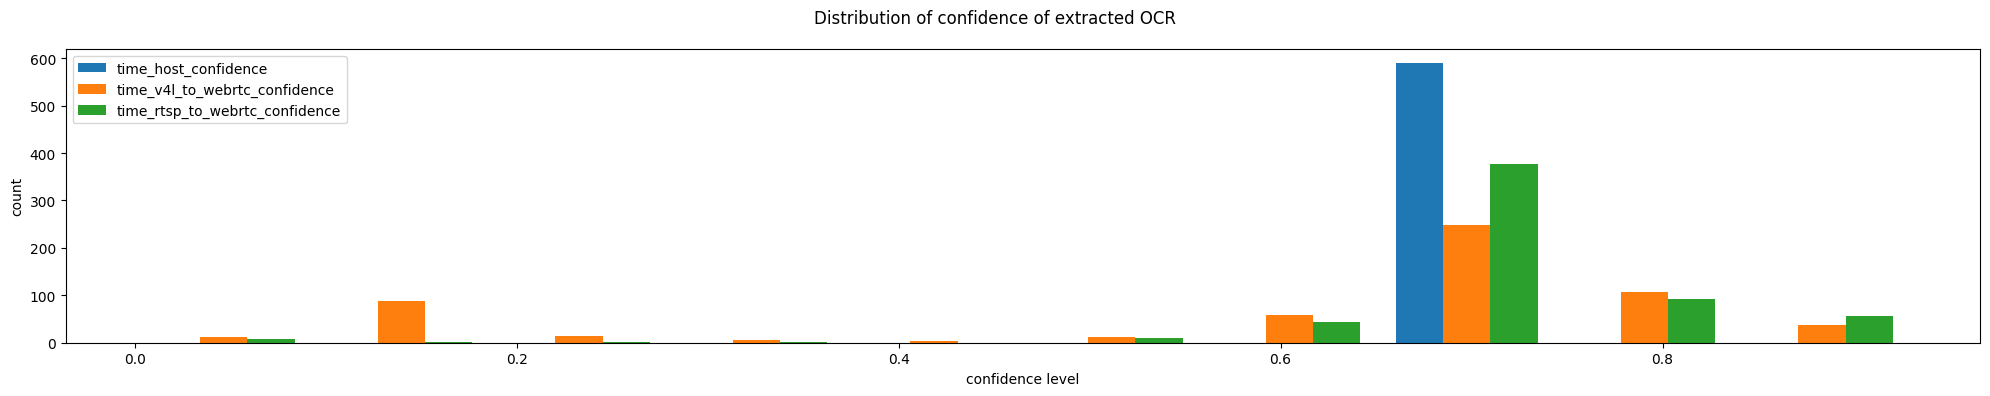

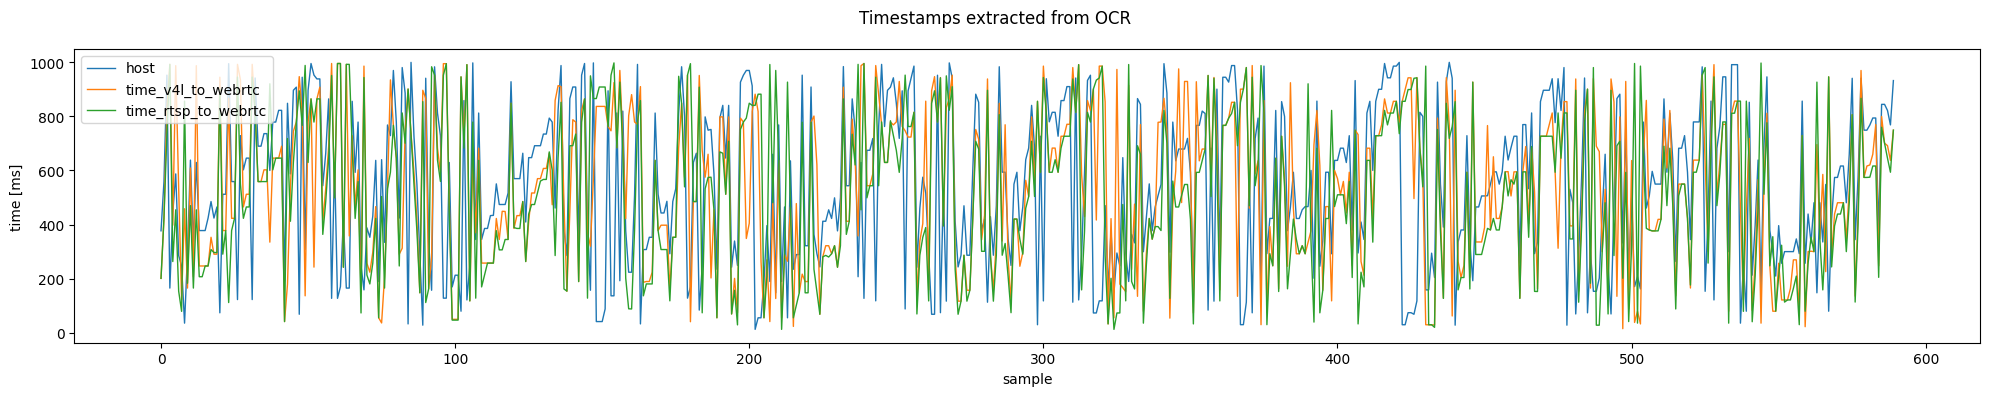

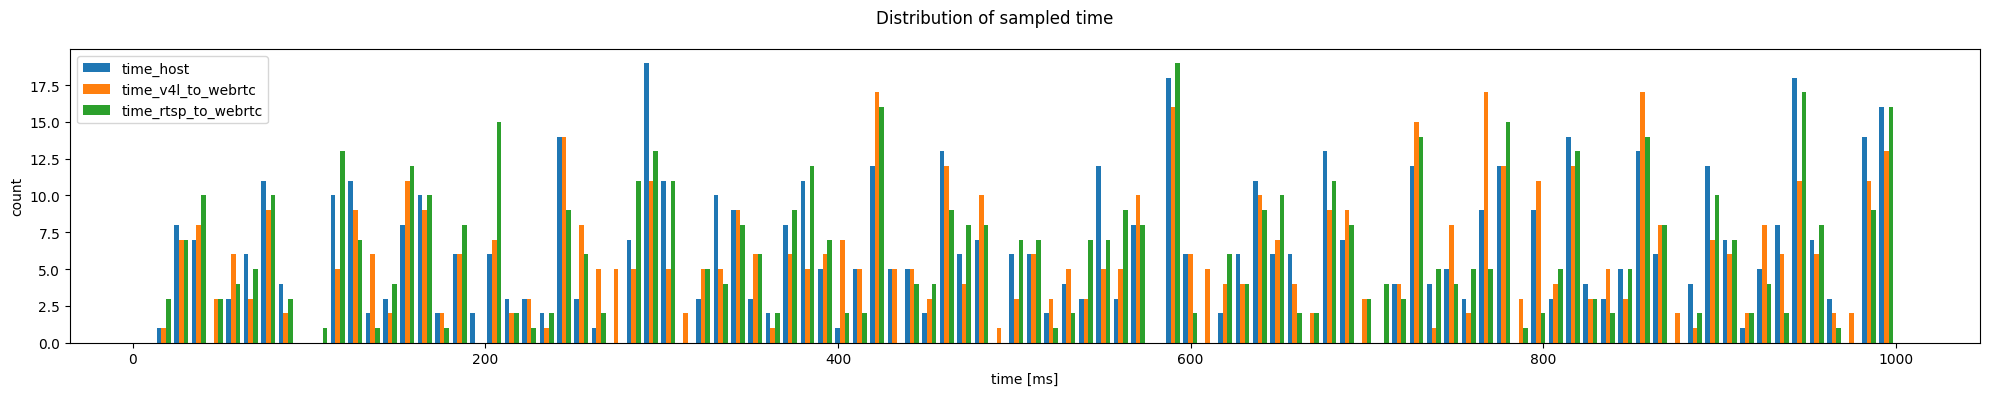

In [457]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of confidence of extracted OCR')
plt.xlabel('confidence level')
plt.ylabel('count')

cols = ['time_host_confidence', 'time_v4l_to_webrtc_confidence', 'time_rtsp_to_webrtc_confidence']
plt.hist(df[cols], 10, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Timestamps extracted from OCR')
plt.xlabel('sample')
plt.ylabel('time [ms]')

plt.plot(df.index, df['time_host'], label='host', lw=1)
plt.plot(df.index, df['time_v4l_to_webrtc'], label='time_v4l_to_webrtc', lw=1)
plt.plot(df.index, df['time_rtsp_to_webrtc'], label='time_rtsp_to_webrtc', lw=1)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of sampled time')
plt.xlabel('time [ms]')
plt.ylabel('count')

cols = ['time_host', 'time_v4l_to_webrtc', 'time_rtsp_to_webrtc']
plt.hist(df[cols], 100, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [465]:
# Filter out low-confidence values
confidence_threshold = 0.58

print(f'Length before filtering out values with confidence lower than {confidence_threshold}:', len(df))
df = df[df['time_host_confidence'] >= confidence_threshold]
df = df[df['time_rtsp_to_webrtc_confidence'] >= confidence_threshold]
df = df[df['time_v4l_to_webrtc_confidence'] >= confidence_threshold]
print(f'Length after filtering out values with confidence lower than {confidence_threshold}:', len(df))

df.describe()

KeyError: '25%'

In [459]:
# Filter out outliers
from scipy import stats

# Compute Z-score for each column
z = np.abs(stats.zscore(df))

# Define threshold for outlier detection
z_score_threshold = 2

print(f'Length before filtering by z-score of {z_score_threshold}:', len(df))

# Filter out rows with any values above threshold
df = df[(z < z_score_threshold).all(axis=1)]

print(f'Length after filtering by z-score of {z_score_threshold}:', len(df))

df.reset_index(drop=True)

df.describe()

Length before filtering by z-score of 2: 423
Length after filtering by z-score of 2: 326


,time_v4l_to_webrtc_confidence,time_rtsp_to_webrtc_confidence,time_host_confidence,time_v4l_to_webrtc,time_rtsp_to_webrtc,time_host,delay_v4l_to_webrtc,delay_rtsp_to_webrtc,jitter_v4l_to_webrtc,jitter_rtsp_to_webrtc
count,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000
mean,0.723589,0.735123,0.715552,474.600453,439.527670,604.161829,142.124046,168.808325,107.350868,99.759248
std,0.052451,0.044138,0.004977,251.392667,252.462762,247.940977,57.440449,45.183199,42.851681,38.087721
min,0.610000,0.640000,0.710000,22.501610,12.606320,147.755350,4.482740,30.819320,6.852142,0.028895
25%,0.690000,0.720000,0.710000,257.572480,216.126685,386.158908,129.269328,135.125628,98.209662,86.963960
50%,0.720000,0.730000,0.720000,473.522255,430.938165,598.280165,132.254580,173.583560,110.377412,92.116365
75%,0.750000,0.740000,0.720000,688.198643,645.517630,818.212348,159.165738,178.627280,113.394522,130.529892
max,0.850000,0.850000,0.720000,973.255570,988.026190,999.480120,678.344210,680.388970,435.892908,414.818705


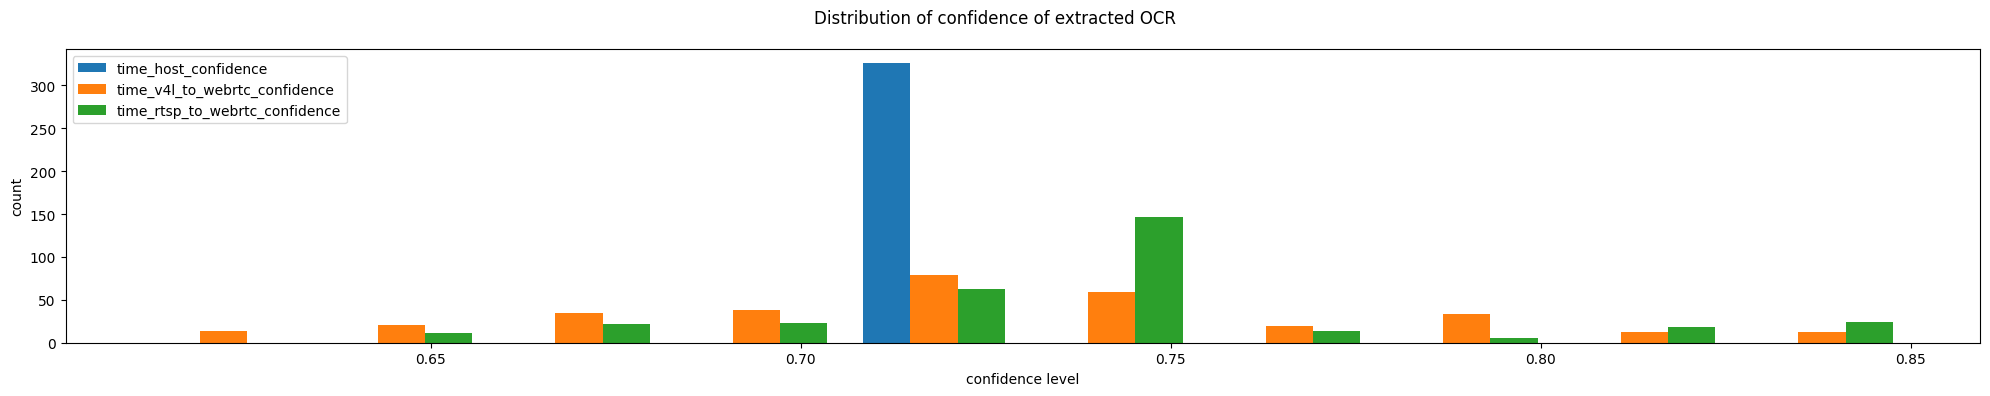

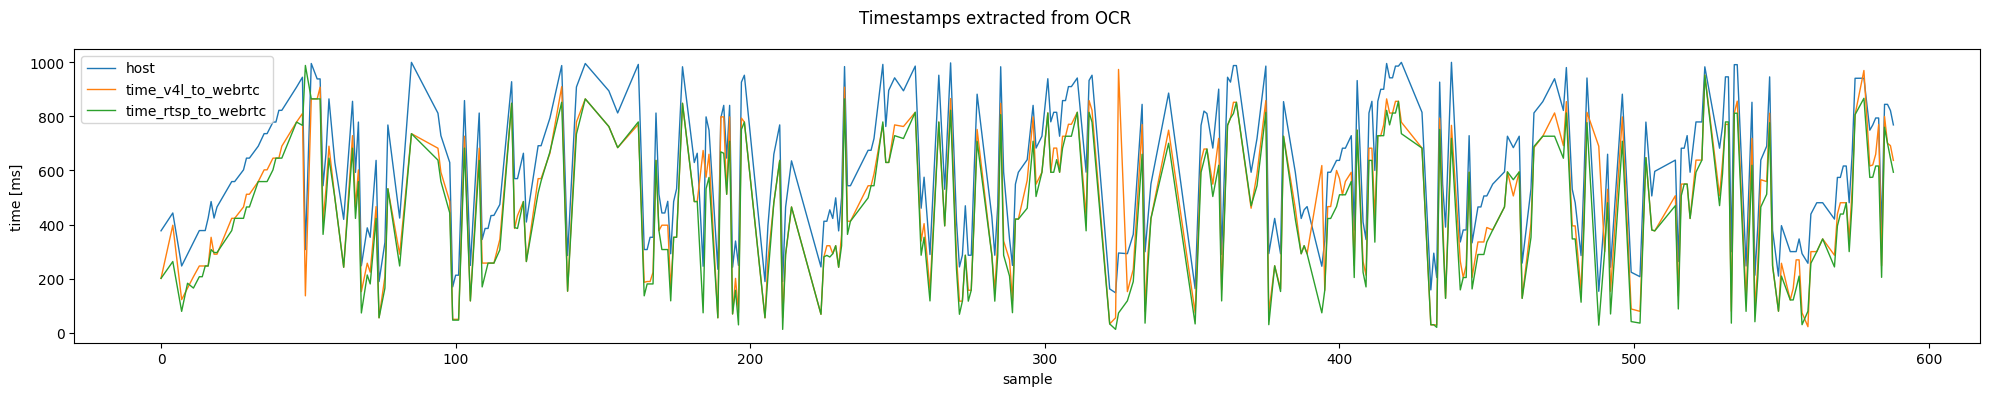

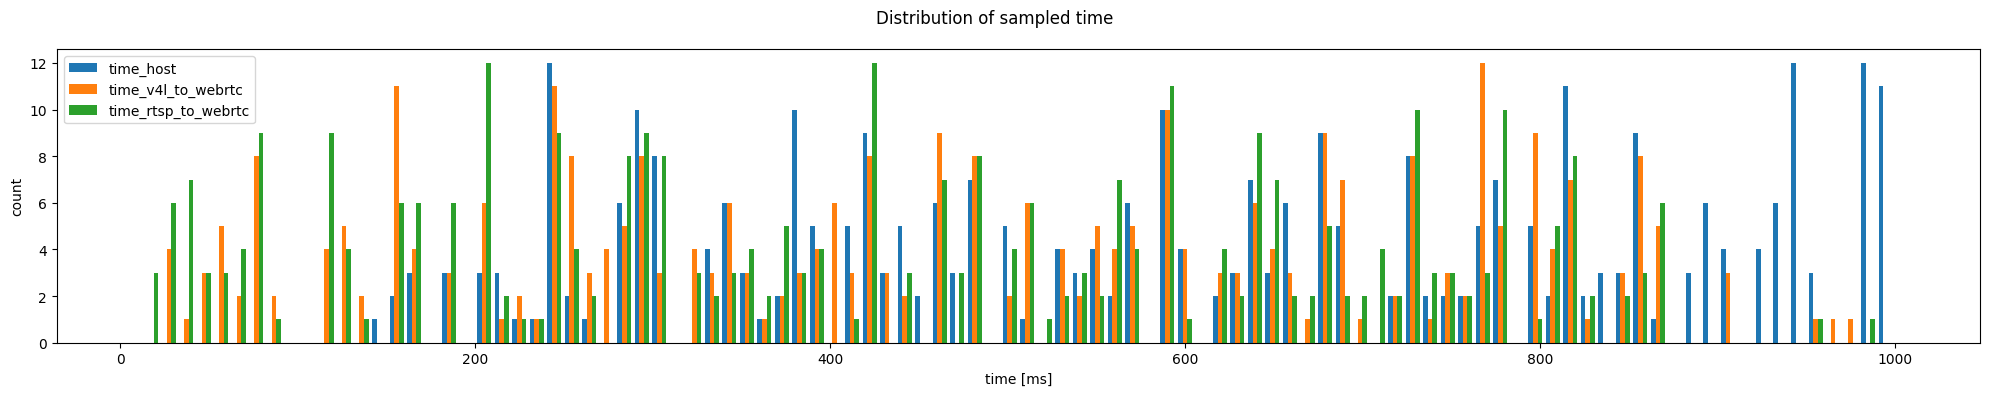

In [460]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of confidence of extracted OCR')
plt.xlabel('confidence level')
plt.ylabel('count')

cols = ['time_host_confidence', 'time_v4l_to_webrtc_confidence', 'time_rtsp_to_webrtc_confidence']
plt.hist(df[cols], 10, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Timestamps extracted from OCR')
plt.xlabel('sample')
plt.ylabel('time [ms]')

plt.plot(df.index, df['time_host'], label='host', lw=1)
plt.plot(df.index, df['time_v4l_to_webrtc'], label='time_v4l_to_webrtc', lw=1)
plt.plot(df.index, df['time_rtsp_to_webrtc'], label='time_rtsp_to_webrtc', lw=1)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of sampled time')
plt.xlabel('time [ms]')
plt.ylabel('count')

cols = ['time_host', 'time_v4l_to_webrtc', 'time_rtsp_to_webrtc']
plt.hist(df[cols], 100, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

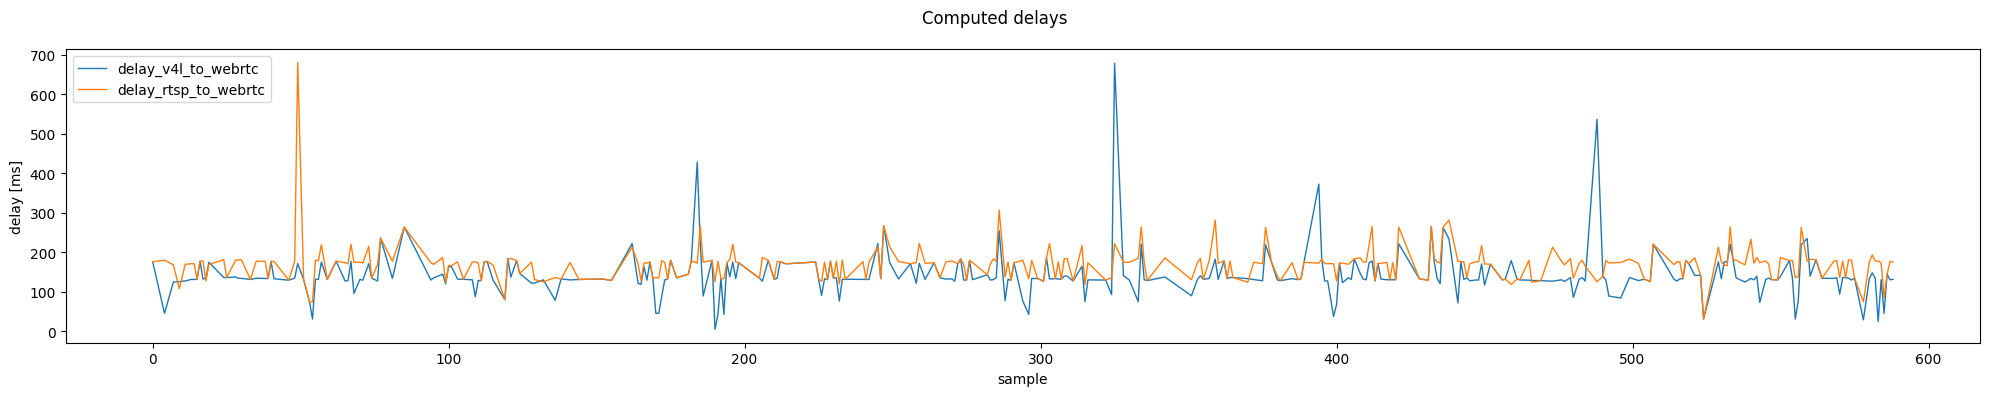

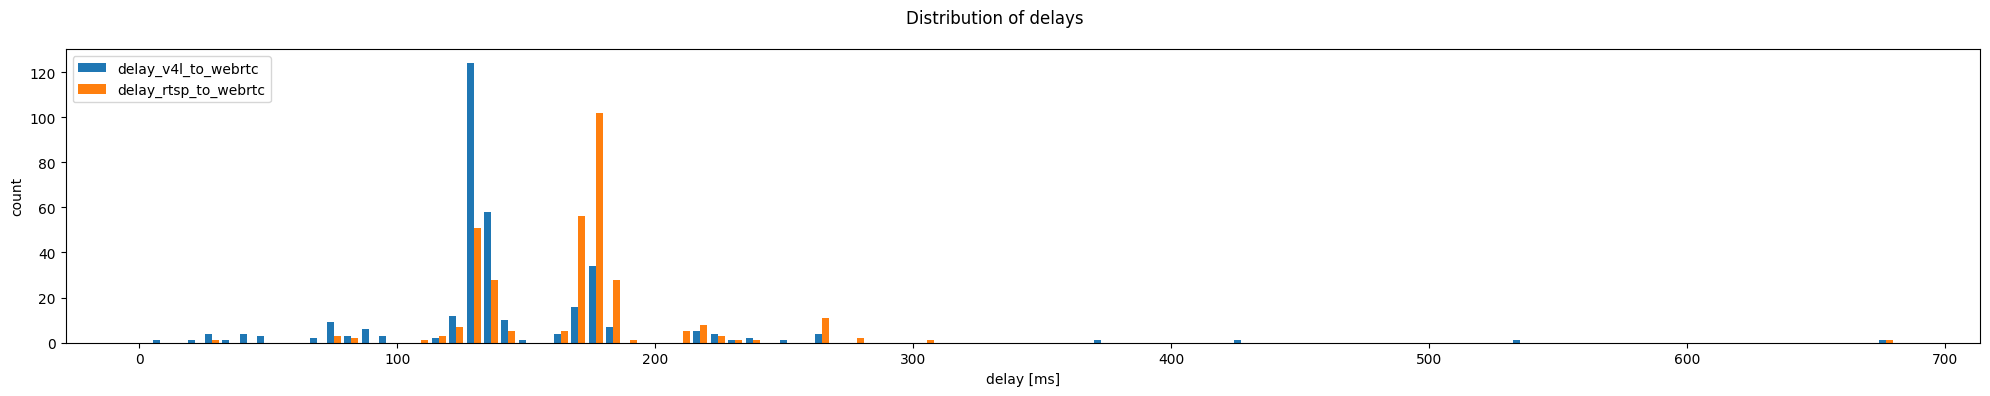

In [461]:
plt.figure(figsize=(20,4))

plt.suptitle('Computed delays')
plt.xlabel('sample')
plt.ylabel('delay [ms]')

plt.plot(df.index, df['delay_v4l_to_webrtc'], label='delay_v4l_to_webrtc', lw=1)
plt.plot(df.index, df['delay_rtsp_to_webrtc'], label='delay_rtsp_to_webrtc', lw=1)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of delays')
plt.xlabel('delay [ms]')
plt.ylabel('count')

cols = ['delay_v4l_to_webrtc', 'delay_rtsp_to_webrtc']
plt.hist(df[cols], 100, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


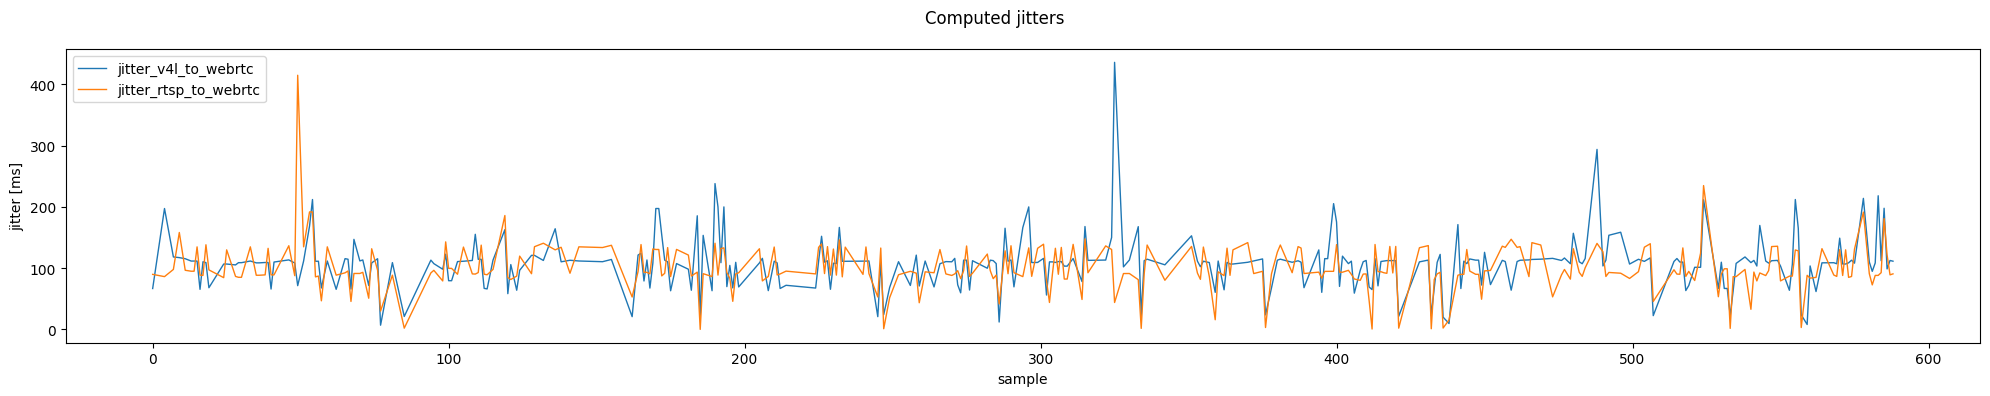

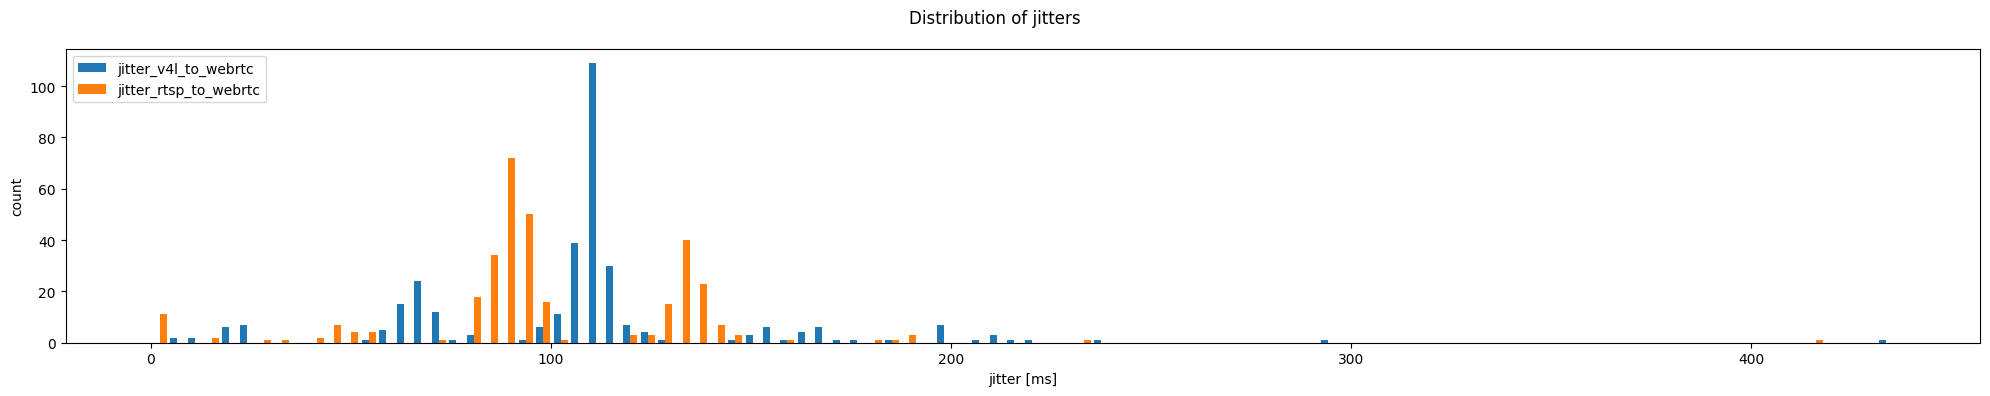

In [462]:
plt.figure(figsize=(20,4))

plt.suptitle('Computed jitters')
plt.xlabel('sample')
plt.ylabel('jitter [ms]')

plt.plot(df.index, df['jitter_v4l_to_webrtc'], label='jitter_v4l_to_webrtc', lw=1)
plt.plot(df.index, df['jitter_rtsp_to_webrtc'], label='jitter_rtsp_to_webrtc', lw=1)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of jitters')
plt.xlabel('jitter [ms]')
plt.ylabel('count')

cols = ['jitter_v4l_to_webrtc', 'jitter_rtsp_to_webrtc']
plt.hist(df[cols], 100, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


# Evaluation

Now that we know that it's a possible way to measure latency, let's tune it further

# Testing different fonts

In [606]:
from PIL import Image, ImageDraw, ImageFont
import cv2
import pytesseract
import pandas as pd
import numpy as np
import matplotlib.font_manager
import multiprocessing
from tqdm import tqdm


def create_image(font, groundtruth_text: str):
    # Get the width and height of the text with the current font
    draw = ImageDraw.Draw(Image.new('RGB', (400, 400), (0, 0, 0)))
    txt_width, txt_height = draw.textsize(groundtruth_text, font=font)

    # Create the image with enough size
    img_width, img_height = int(txt_width*1.2),int(txt_height*1.8)
    img = Image.new('RGB', (img_width, img_height), (0, 0, 0))

    # Create a draw object for the image
    draw = ImageDraw.Draw(img)

    # Calculate the x-coordinate for centering the text
    center_x = (img_width - txt_width) / 2
    center_y = (img_height - txt_height) / 2

    # Draw the text with the current font
    draw.text((center_x, center_y), groundtruth_text, font=font, fill=(0, 255, 0))

    img = cv.cvtColor(np.array(img), cv.IMREAD_GRAYSCALE)

    return img

def extract_text(img, groundtruth_text) -> dict:
    # Transform it into pure black'n'white using a simple global threshold
    _,img = cv.threshold(img, 127, 255, cv.THRESH_BINARY)

    # 
    custom_config = r'--oem 0 --psm 12 --dpi 300 -c tessedit_char_whitelist="0123456789 :"'
    data = pytesseract.image_to_data(img, lang='eng', config=custom_config, nice=0, output_type=pytesseract.Output.DICT)

    extracted_text = ''
    extracted_confidence = np.NaN
    for i in range(len(data['text'])):
        text = data['text'][i]
        confidence = float(data['conf'][i]) / 100
        if confidence > 0:
            extracted_confidence = confidence
            extracted_text = text

    return {
        'confidence': extracted_confidence,
        'value': extracted_text,
        'correct': extracted_text == groundtruth_text,
    }

def create_and_extract(vars: dict) -> dict | None:
    font_path = vars['font_path']
    font_size = vars['font_size']
    groundtruth_text = vars['groundtruth_text']

    try:
        # Create a font object with the specified size and path
        font = ImageFont.truetype(font_path, font_size)

        # Create our black image with green text
        img = create_image(font, groundtruth_text)

        # Extract the written text with OCR
        data = extract_text(img, groundtruth_text)

        data['font'] = font.getname()

        return data

    except Exception as e:
        return None

def test_all_system_fonts() -> pd.DataFrame:
    # Load all tff system fonts
    system_fonts = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

    # Define the text to be drawn
    groundtruth_text = ':0123456789'

    # Define the font size and paths to the font files
    font_size = 128

    # Get the number of CPUs and available memory
    num_cpus = psutil.cpu_count(logical=False)
    mem_stats = psutil.virtual_memory()
    mem_avail = mem_stats.available / (1024 * 1024 * 1024)

    # Limit the number of processes based on the available resources
    max_processes = min(num_cpus, int(mem_avail * 1.5), 15)
    num_processes = max(1, max_processes)

    # Create a process pool with the specified number of processes
    pool = multiprocessing.Pool(num_processes)

    # Create a multiprocessing pool with the specified number of processes
    with multiprocessing.Pool(processes=num_processes) as pool:
        # Map the create_and_extract function to the list of font paths in parallel
        args = [{
            'font_path': font_path, 'font_size': font_size, 'groundtruth_text': groundtruth_text
        } for font_path in system_fonts]
        results = list(tqdm(pool.imap_unordered(create_and_extract, args), total=len(system_fonts)))

    # Extract the actual results from the async results objects
    results = [result for result in results if result]

    return pd.DataFrame(results)

df = test_all_system_fonts()
df

100%|██████████| 1136/1136 [00:34<00:00, 32.54it/s]


In [610]:
df = df[df['correct'] == True]
df = df.sort_values('confidence', ascending=False).reset_index(drop=True)
df

,confidence,value,correct,font
0,0.91,:0123456789,True,"(Ubuntu, Medium)"
1,0.90,:0123456789,True,"(FreeMono, Bold)"
2,0.90,:0123456789,True,"(Noto Sans Sinhala UI, Bold)"
3,0.90,:0123456789,True,"(Noto Sans Sinhala, Bold)"
4,0.90,:0123456789,True,"(Courier Prime Sans, Regular)"
...,...,...,...,...
385,0.70,:0123456789,True,"(Merriweather, Black)"
386,0.69,:0123456789,True,"(Noto Serif Telugu, Thin)"
387,0.67,:0123456789,True,"(Serto Jerusalem, Regular)"
388,0.66,:0123456789,True,"(Estrangelo Midyat, Regular)"


# Record with the best available font and try again

Ok, now that we know that there are better fonts to use with Tesseract, let's record the video again and rerun the extraction and analysis

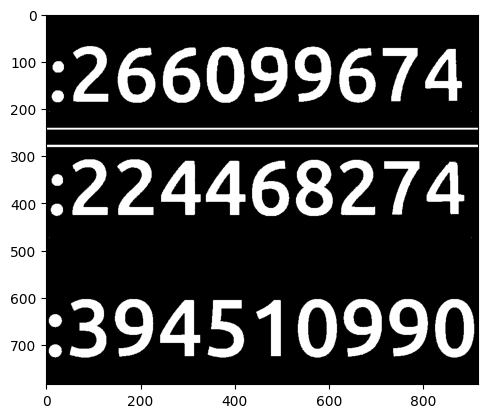

In [674]:
filename = 'extracted_images/rtsp_to_webrtc_better/img000002.png'

img = cv.imread(filename, cv.IMREAD_GRAYSCALE)
_,img = cv.threshold(img, 60, 255, cv.THRESH_BINARY)

plt.imshow(img, 'gray')

In [675]:
import pytesseract
import re

custom_config = r'--oem 0 --psm 12 --dpi 300 -c tessedit_char_whitelist="0123456789 :"'
data = pytesseract.image_to_data(img, lang='eng', config=custom_config, nice=0, output_type=pytesseract.Output.DICT)
display(data)

matches = []
for i in range(len(data['text'])):
    text = data['text'][i]
    conf = float(data['conf'][i]) / 100
    matched = re.findall(r'\d{9}(?=[\s:]|$)', text)
    for match in matched:
        matches.append((conf, int(match)))

matches

{'level': [1, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5],
 'page_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'block_num': [0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
 'par_num': [0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
 'line_num': [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
 'word_num': [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
 'left': [0, 12, 12, 12, 12, 10, 10, 10, 10, 6, 6, 6, 6],
 'top': [0, 68, 68, 68, 68, 308, 308, 308, 308, 604, 604, 604, 604],
 'width': [916, 870, 870, 870, 870, 877, 877, 877, 877, 902, 902, 902, 902],
 'height': [784, 120, 120, 120, 120, 120, 120, 120, 120, 124, 124, 124, 124],
 'conf': [-1, -1, -1, -1, 90, -1, -1, -1, 90, -1, -1, -1, 89],
 'text': ['',
  '',
  '',
  '',
  ':266099674',
  '',
  '',
  '',
  ':224468274',
  '',
  '',
  '',
  ':394510990']}

[(0.9, 266099674), (0.9, 224468274), (0.89, 394510990)]

In [676]:
import cv2 as cv
import pytesseract
import glob
import re
import multiprocessing
import psutil
from tqdm import tqdm
from typing import List, Tuple

def extract_numbers(filename: str) -> List[Tuple[float, int]]:
    try:
        img = cv.imread(filename, cv.IMREAD_GRAYSCALE)
        _, img = cv.threshold(img, 60, 255, cv.THRESH_BINARY)

        # https://ai-facets.org/tesseract-ocr-best-practices/
        custom_config = r'--oem 0 --psm 12 --dpi 300 -c tessedit_char_whitelist="0123456789 :"'
        # custom_config = r'--oem 1 --psm 12'
        data = pytesseract.image_to_data(img, lang='eng', config=custom_config, output_type=pytesseract.Output.DICT)

        matches = []
        for i in range(len(data['text'])):
            text = data['text'][i]
            conf = float(data['conf'][i]) / 100
            matched = re.findall(r'\d{9}(?=[\s:]|$)', text)
            for match in matched:
                matches.append((conf, int(match)))

        return matches

    except (cv.error, pytesseract.TesseractError, ValueError):
        return []


def extract_numbers_parallel(pattern: str) -> List[Tuple[str, List[Tuple[float,int]]]]:
    files = glob.glob(pattern)

    # Get the number of CPUs and available memory
    num_cpus = psutil.cpu_count(logical=False)
    mem_stats = psutil.virtual_memory()
    mem_avail = mem_stats.available / (1024 * 1024 * 1024)

    # Limit the number of processes based on the available resources
    max_processes = min(num_cpus, int(mem_avail * 1.5), 15)
    num_processes = max(1, max_processes)

    with multiprocessing.Pool(processes=num_processes) as pool:
        results = list(tqdm(pool.imap_unordered(extract_numbers, files), total=len(files)))

    return list(zip(files, results))

numbers = extract_numbers_parallel('extracted_images/rtsp_to_webrtc_better/img*.png')

100%|██████████| 3659/3659 [02:36<00:00, 23.37it/s]


In [684]:
import pandas as pd
import numpy as np

df = numbers_to_dataframe(numbers)

df = df.rename(columns={
    '0_confidence': 'time_v4l_to_webrtc_confidence',
    '1_confidence': 'time_rtsp_to_webrtc_confidence',
    '2_confidence': 'time_host_confidence',
    '0_value': 'time_v4l_to_webrtc',
    '1_value': 'time_rtsp_to_webrtc',
    '2_value': 'time_host',
})
df = df.set_index('filename', drop=True).sort_index().reset_index(drop=True)

# Scale to milliseconds (from an 9-digits number after the seconds comma)
df['time_host'] = df['time_host'] * 1e-6
df['time_v4l_to_webrtc'] = df['time_v4l_to_webrtc'] * 1e-6
df['time_rtsp_to_webrtc'] = df['time_rtsp_to_webrtc'] * 1e-6

# Compute latencies - because time is warping each second, we get the absolute values
df['delay_v4l_to_webrtc'] = np.abs(df['time_host'] - df['time_v4l_to_webrtc'])
df['delay_rtsp_to_webrtc'] = np.abs(df['time_host'] - df['time_rtsp_to_webrtc'])

# Computed jitter
df['jitter_v4l_to_webrtc'] = np.abs(df['delay_v4l_to_webrtc'].mean() - df['delay_v4l_to_webrtc'])
df['jitter_rtsp_to_webrtc'] = np.abs(df['delay_rtsp_to_webrtc'].mean() - df['delay_rtsp_to_webrtc'])

df.describe()


,time_v4l_to_webrtc_confidence,time_rtsp_to_webrtc_confidence,time_host_confidence,time_v4l_to_webrtc,time_rtsp_to_webrtc,time_host,delay_v4l_to_webrtc,delay_rtsp_to_webrtc,jitter_v4l_to_webrtc,jitter_rtsp_to_webrtc
count,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000
mean,0.877554,0.878635,0.898022,503.169777,504.626343,502.725112,264.487142,308.905095,184.371788,193.109865
std,0.065869,0.059812,0.006398,286.898090,287.424608,286.984281,252.383384,245.496620,172.321409,151.546943
min,0.270000,0.300000,0.870000,2.091232,2.091232,2.091232,3.782343,69.720891,4.587794,10.841459
25%,0.890000,0.890000,0.890000,258.089693,257.742127,256.214144,131.791366,173.947443,90.652241,93.260987
50%,0.900000,0.900000,0.900000,505.458773,504.416677,506.140854,172.052655,197.882371,132.095239,134.671332
75%,0.910000,0.900000,0.900000,742.375135,746.544887,742.326137,176.080161,219.733776,136.178987,138.862813
max,0.920000,0.920000,0.920000,998.825473,998.825473,998.825473,930.702164,886.256701,666.215022,577.351606


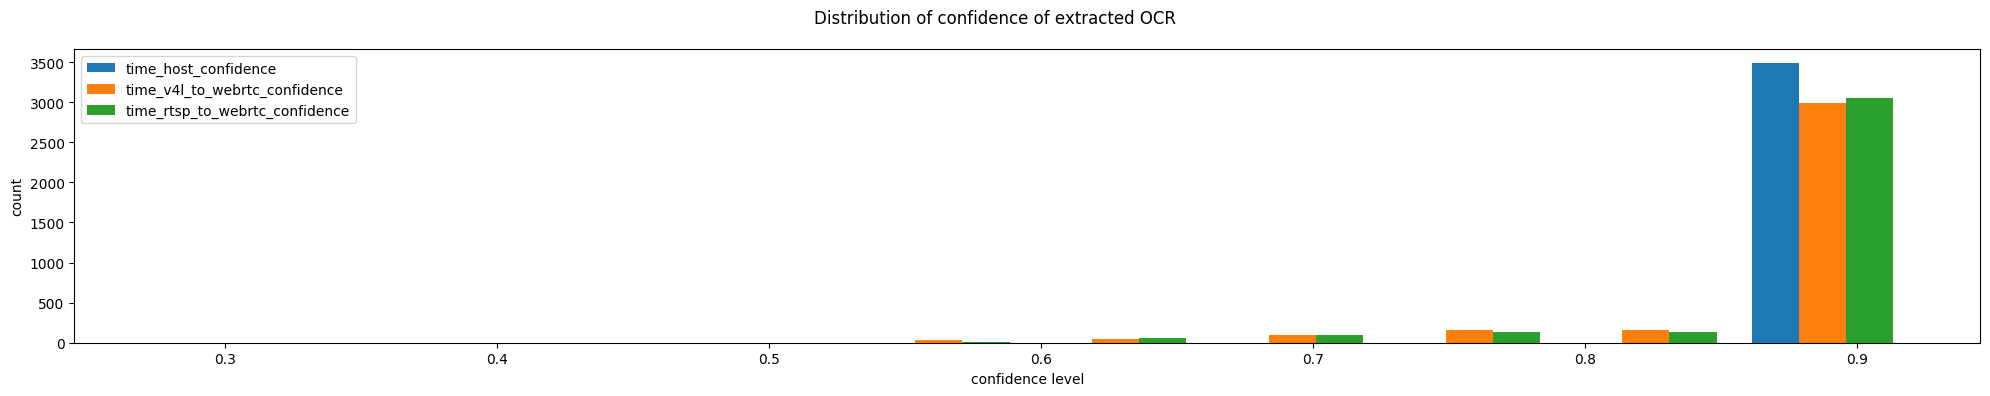

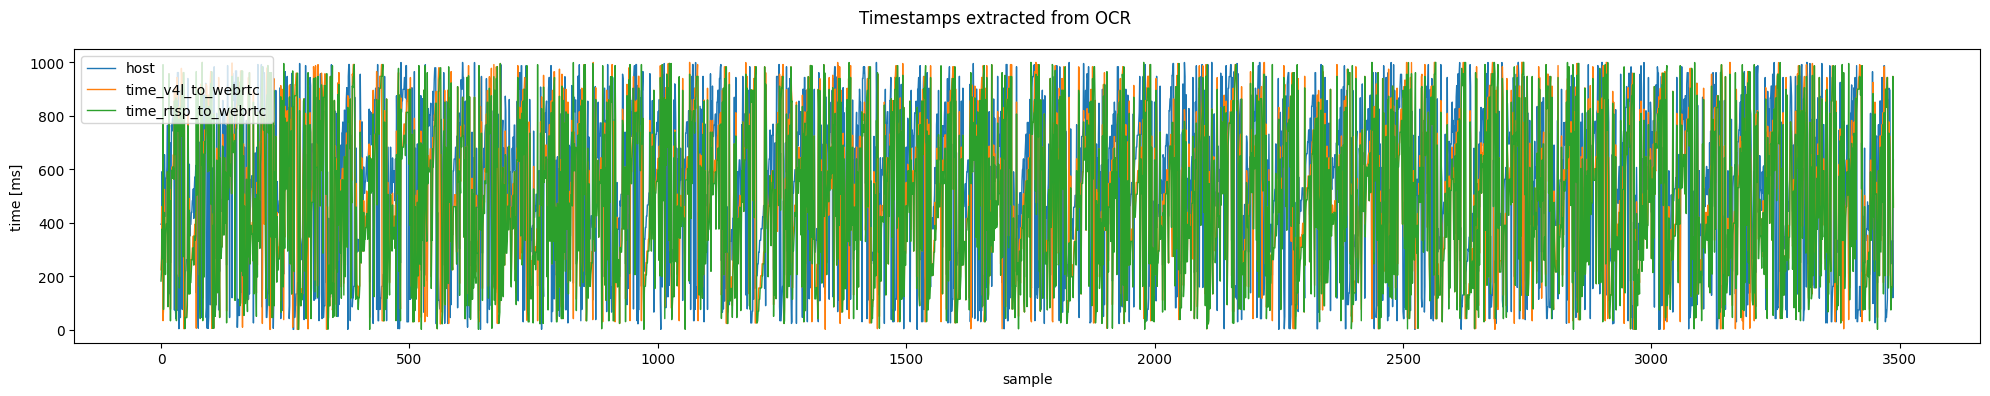

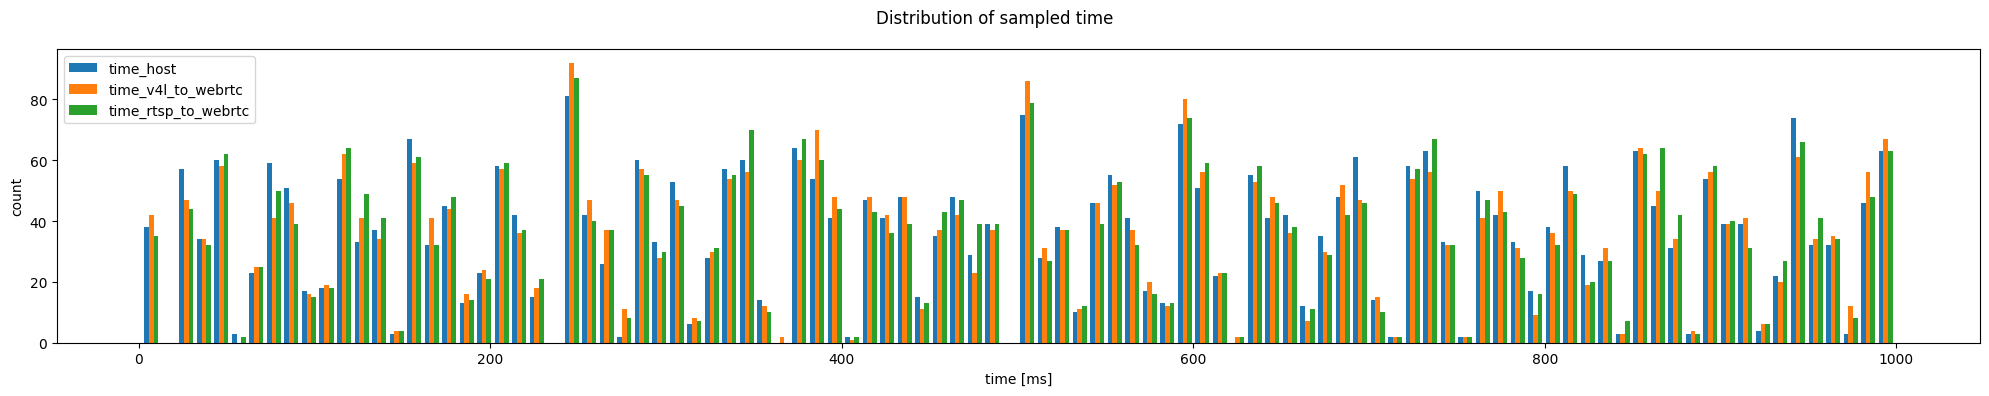

In [685]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of confidence of extracted OCR')
plt.xlabel('confidence level')
plt.ylabel('count')

cols = ['time_host_confidence', 'time_v4l_to_webrtc_confidence', 'time_rtsp_to_webrtc_confidence']
plt.hist(df[cols], 10, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Timestamps extracted from OCR')
plt.xlabel('sample')
plt.ylabel('time [ms]')

plt.plot(df.index, df['time_host'], label='host', lw=1)
plt.plot(df.index, df['time_v4l_to_webrtc'], label='time_v4l_to_webrtc', lw=1)
plt.plot(df.index, df['time_rtsp_to_webrtc'], label='time_rtsp_to_webrtc', lw=1)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of sampled time')
plt.xlabel('time [ms]')
plt.ylabel('count')

cols = ['time_host', 'time_v4l_to_webrtc', 'time_rtsp_to_webrtc']
plt.hist(df[cols], 100, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [686]:
# Filter out low-confidence values
confidence_threshold = 0.87

print(f'Length before filtering out values with confidence lower than {confidence_threshold}:', len(df))
df = df[df['time_host_confidence'] >= confidence_threshold]
df = df[df['time_rtsp_to_webrtc_confidence'] >= confidence_threshold]
df = df[df['time_v4l_to_webrtc_confidence'] >= confidence_threshold]
print(f'Length after filtering out values with confidence lower than {confidence_threshold}:', len(df))

df.describe()

Length before filtering out values with confidence lower than 0.87: 3488
Length after filtering out values with confidence lower than 0.87: 2554


,time_v4l_to_webrtc_confidence,time_rtsp_to_webrtc_confidence,time_host_confidence,time_v4l_to_webrtc,time_rtsp_to_webrtc,time_host,delay_v4l_to_webrtc,delay_rtsp_to_webrtc,jitter_v4l_to_webrtc,jitter_rtsp_to_webrtc
count,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000
mean,0.901081,0.898653,0.897960,497.227739,499.897550,499.937495,258.697749,306.453280,181.416375,191.544107
std,0.008199,0.008419,0.006298,289.250393,289.987798,284.971785,248.220737,243.380669,169.476464,150.122110
min,0.870000,0.870000,0.880000,2.091232,2.091232,2.113956,85.540386,126.077625,44.470644,45.042813
25%,0.900000,0.890000,0.890000,246.314348,246.387026,254.524363,131.700177,173.959146,90.686740,93.263380
50%,0.900000,0.900000,0.900000,504.638350,502.417469,502.347784,172.013732,178.466637,132.132915,134.629906
75%,0.910000,0.900000,0.900000,742.620824,746.446571,738.339145,176.007213,219.462884,134.971817,137.937155
max,0.920000,0.920000,0.920000,998.825473,998.825473,998.661832,873.413122,872.106551,608.925980,563.201456


In [693]:
# Filter out outliers
from scipy import stats

# Compute Z-score for each column
z = np.abs(stats.zscore(df))

# Define threshold for outlier detection
z_score_threshold = 1.5

print(f'Length before filtering by z-score of {z_score_threshold}:', len(df))

# Filter out rows with any values above threshold
df = df[(z < z_score_threshold).all(axis=1)]

print(f'Length after filtering by z-score of {z_score_threshold}:', len(df))

df.reset_index(drop=True)

df.describe()

Length before filtering by z-score of 1.5: 2554
Length after filtering by z-score of 1.5: 1355


,time_v4l_to_webrtc_confidence,time_rtsp_to_webrtc_confidence,time_host_confidence,time_v4l_to_webrtc,time_rtsp_to_webrtc,time_host,delay_v4l_to_webrtc,delay_rtsp_to_webrtc,jitter_v4l_to_webrtc,jitter_rtsp_to_webrtc
count,1355.000000,1355.000000,1355.000000,1355.000000,1355.000000,1355.000000,1355.000000,1355.000000,1355.000000,1355.000000
mean,0.901033,0.899159,0.897107,432.144529,398.153883,586.618047,154.473517,188.464163,110.013625,120.440932
std,0.006599,0.006592,0.004536,194.175930,193.221632,192.824857,23.061315,22.623083,23.061315,22.623083
min,0.890000,0.890000,0.890000,66.844071,66.122161,197.666445,87.810954,126.077625,44.470644,45.042813
25%,0.900000,0.890000,0.890000,259.358342,224.639160,421.451556,130.500686,173.551929,90.321672,92.951440
50%,0.900000,0.900000,0.900000,438.108400,394.209970,590.505028,170.062444,175.940415,94.424698,132.964680
75%,0.910000,0.900000,0.900000,596.465002,562.400353,746.551199,174.165470,215.953655,133.986456,135.353166
max,0.910000,0.910000,0.900000,786.643642,746.558008,920.592844,220.016498,263.862282,176.676188,182.827470


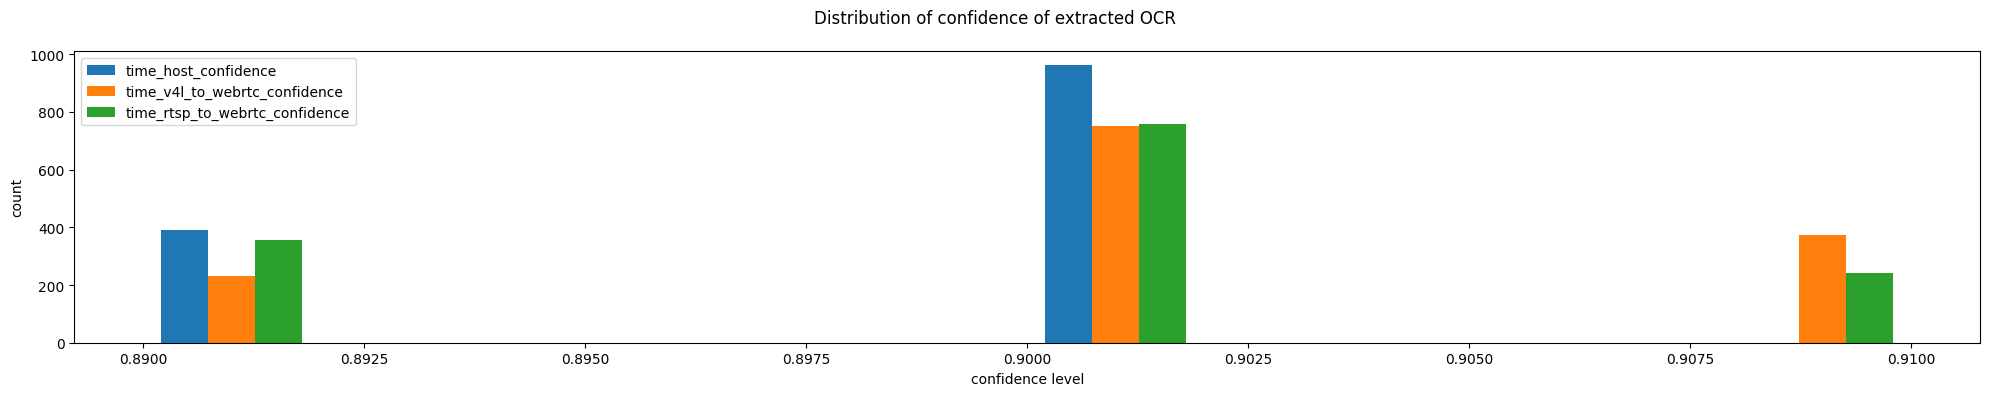

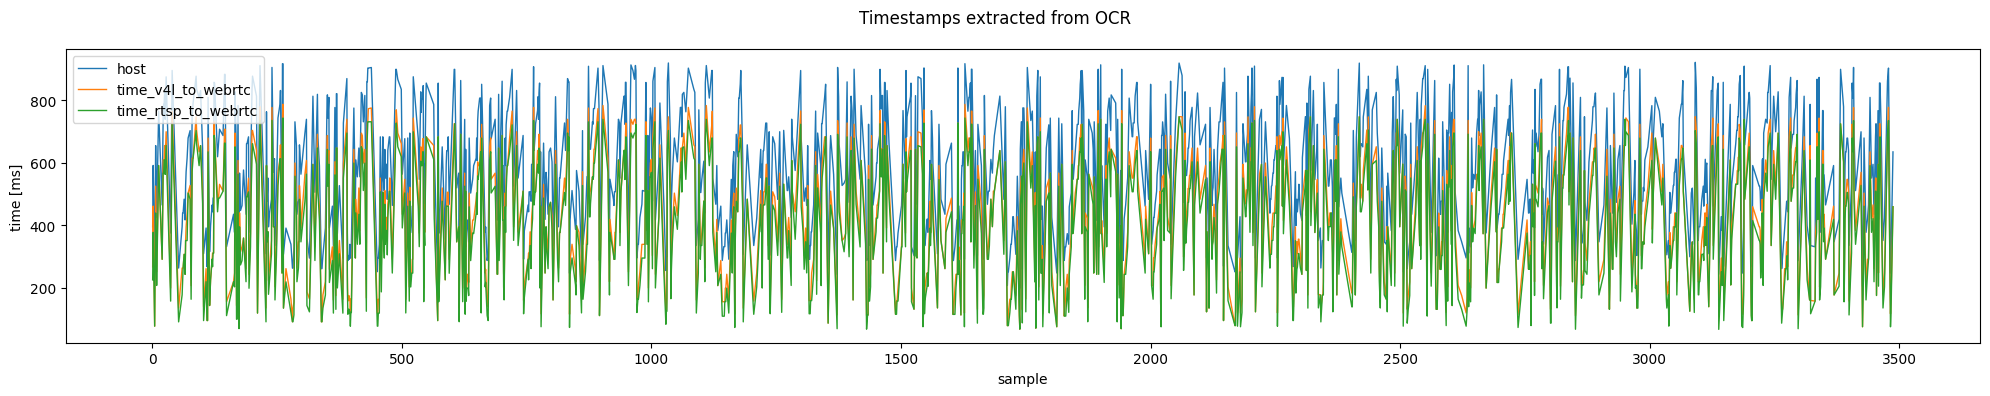

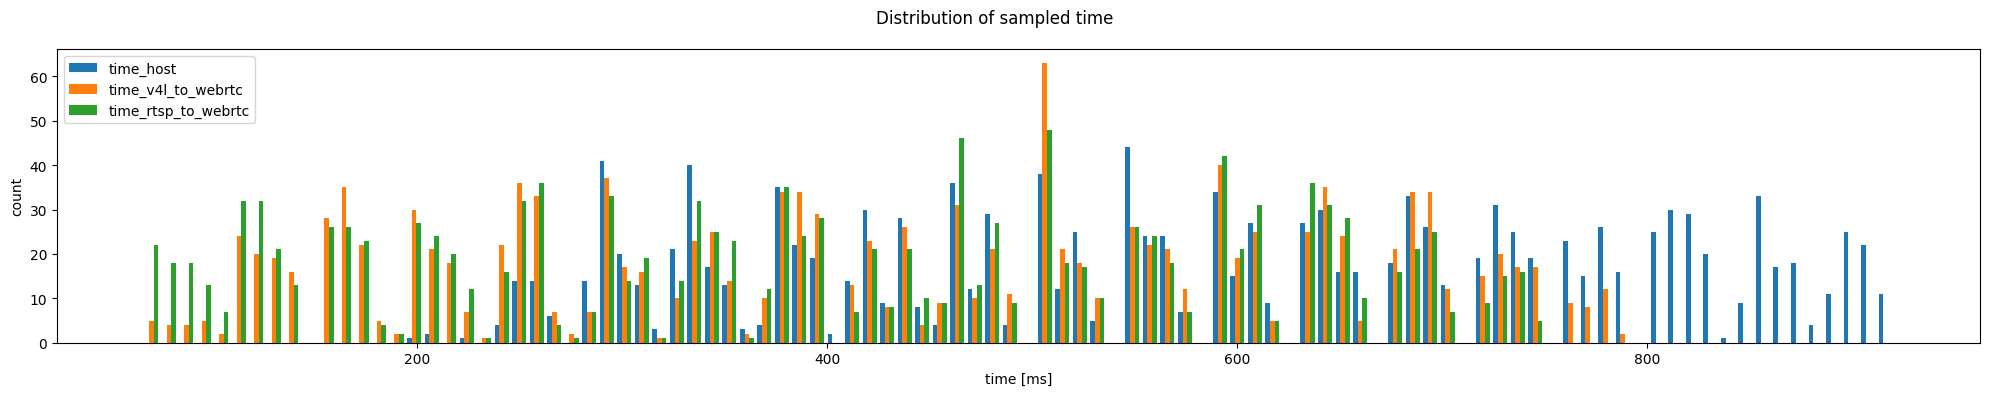

In [694]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of confidence of extracted OCR')
plt.xlabel('confidence level')
plt.ylabel('count')

cols = ['time_host_confidence', 'time_v4l_to_webrtc_confidence', 'time_rtsp_to_webrtc_confidence']
plt.hist(df[cols], 10, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Timestamps extracted from OCR')
plt.xlabel('sample')
plt.ylabel('time [ms]')

plt.plot(df.index, df['time_host'], label='host', lw=1)
plt.plot(df.index, df['time_v4l_to_webrtc'], label='time_v4l_to_webrtc', lw=1)
plt.plot(df.index, df['time_rtsp_to_webrtc'], label='time_rtsp_to_webrtc', lw=1)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of sampled time')
plt.xlabel('time [ms]')
plt.ylabel('count')

cols = ['time_host', 'time_v4l_to_webrtc', 'time_rtsp_to_webrtc']
plt.hist(df[cols], 100, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

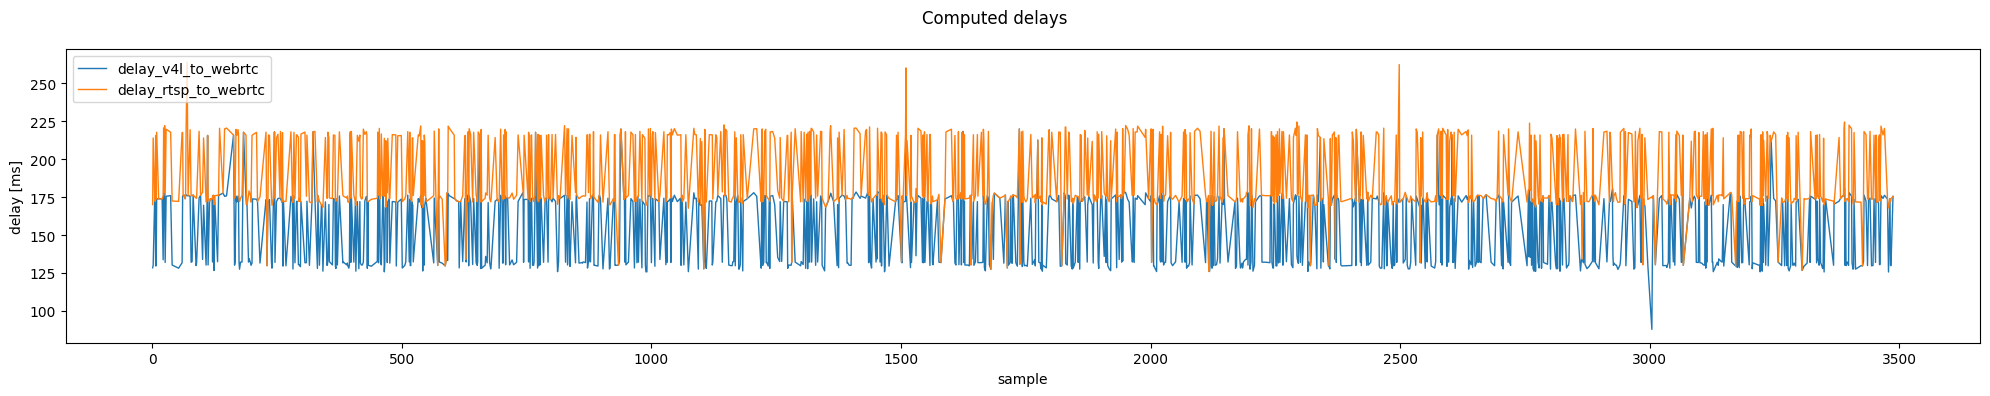

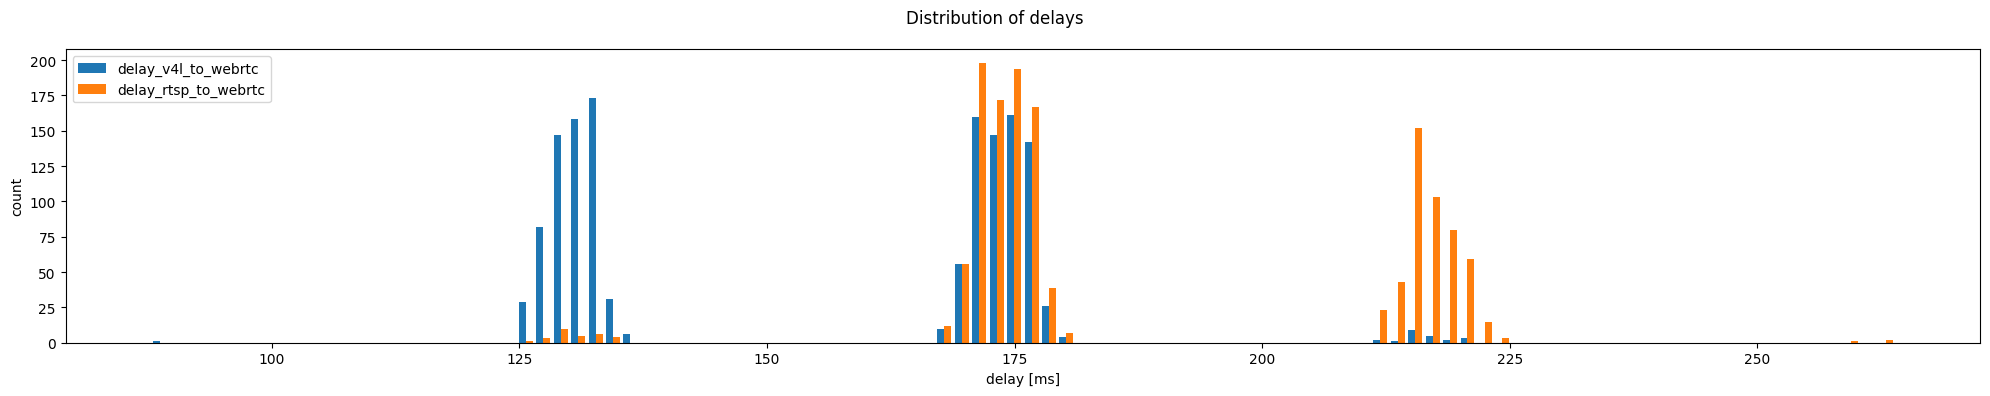

In [695]:
plt.figure(figsize=(20,4))

plt.suptitle('Computed delays')
plt.xlabel('sample')
plt.ylabel('delay [ms]')

plt.plot(df.index, df['delay_v4l_to_webrtc'], label='delay_v4l_to_webrtc', lw=1)
plt.plot(df.index, df['delay_rtsp_to_webrtc'], label='delay_rtsp_to_webrtc', lw=1)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of delays')
plt.xlabel('delay [ms]')
plt.ylabel('count')

cols = ['delay_v4l_to_webrtc', 'delay_rtsp_to_webrtc']
plt.hist(df[cols], 100, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


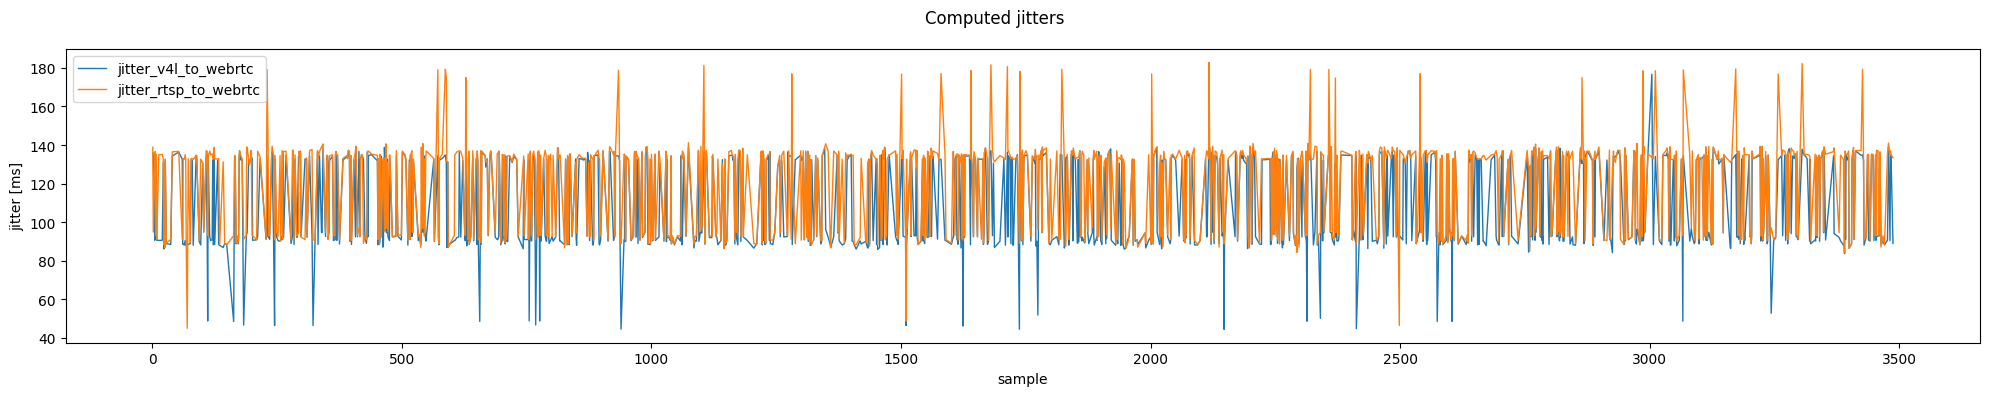

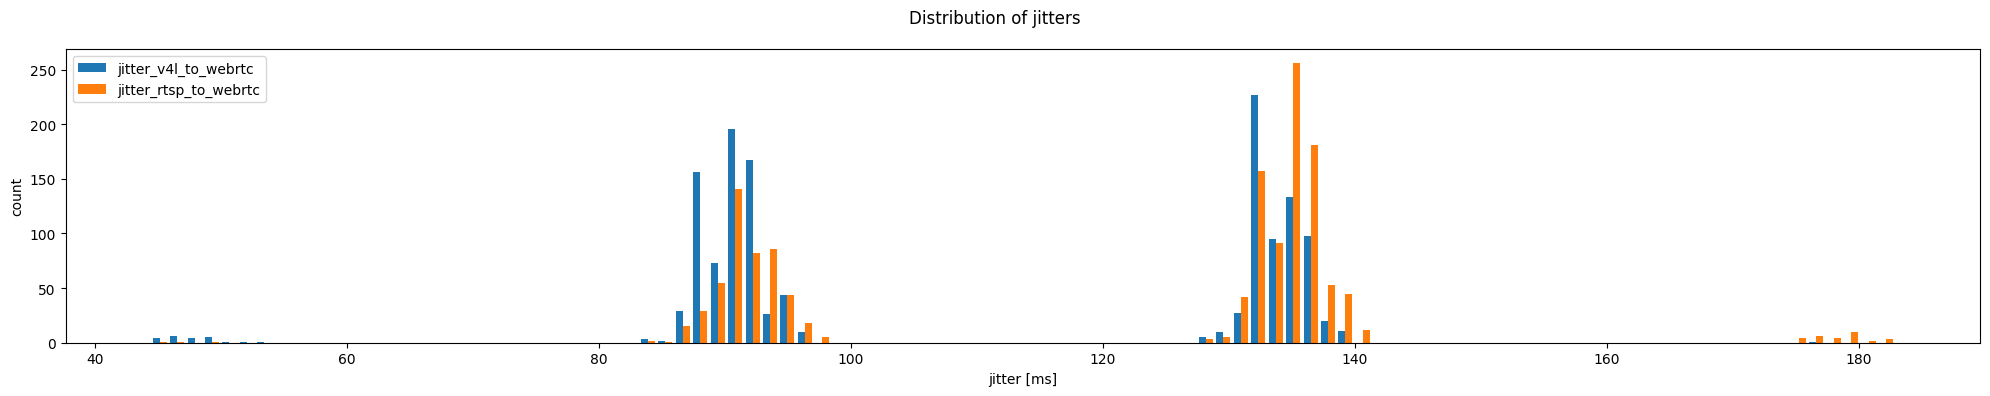

In [696]:
plt.figure(figsize=(20,4))

plt.suptitle('Computed jitters')
plt.xlabel('sample')
plt.ylabel('jitter [ms]')

plt.plot(df.index, df['jitter_v4l_to_webrtc'], label='jitter_v4l_to_webrtc', lw=1)
plt.plot(df.index, df['jitter_rtsp_to_webrtc'], label='jitter_rtsp_to_webrtc', lw=1)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of jitters')
plt.xlabel('jitter [ms]')
plt.ylabel('count')

cols = ['jitter_v4l_to_webrtc', 'jitter_rtsp_to_webrtc']
plt.hist(df[cols], 100, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
